# Lecture 1 - Markov Decision Process & Bellman's equations

**In this notebook you will discover an OpenAI Gym environment**


The aims of this notebook are first, to discover the Open AI Gym package often used in Reinforcement Learning and to understand the concept of value functions by computing it for a given policy.

## Environment setup

In [1]:
# Import the libraries
import time
import numpy as np
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd
from IPython.display import clear_output

sns.set_style("white")
%matplotlib inline

### Open AI Gym - Explore CliffWalking Environment

If not already installed :

In [2]:
!pip3 install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 4.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827616 sha256=33398a3a961fd509f0fb8c47753ca8d412a6761dab55f83a13a6f749478b8a06
  Stored in directory: /Users/ilyeshammouda/Library/Caches/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Open AI Gym is a python library giving huge number of test environments to work on RL agent’s algorithms with shared interfaces for writing general algorithms and testing them. It was created for removing this problem of lack of standardization in papers along with an aim to create better benchmarks by giving versatile numbers of environment with great ease of setting up. Aim of this tool is to increase reproducibility in the field of AI and provide tools with which everyone can learn about basics of AI.

For further informations: https://gym.openai.com/

In [3]:
import gym

In [4]:
# Making an instance of environment

env = gym.make('CliffWalking-v0')

**Q1 - Describe the environnement:** To get familiar with gym, try to observe the different elements of the framework. Test the attributes

1.   observation_space
2.   nS (number of states)
3.   action_space
4.   nA (number of actions)
5.   P (matrice of transitions)

And test the methods :

1.   Reset (allowing to reset the environment to an initial state)
2.   Step (allowing the apply the action to the environment and get the next state and reward)






In [5]:
# Print the state space
print("State Space: \n", env.observation_space, "\n", env.nS)

print("State at start: "+ str(env.reset()))

State Space: 
 Discrete(48) 
 48
State at start: (36, {'prob': 1})


In [6]:
# Print the action space
# TO DO
print("Action Space: \n", env.action_space, "\n", env.nA)

Action Space: 
 Discrete(4) 
 4


In [7]:
# Print the probability matrix
for state in range(env.nS):
    for action in range(env.nA):
        for prob, next_state, reward, done in env.P[state][action]:
            print("State: ", state, "Action: ", action, "Next State: ", next_state, "Reward: ", reward, "Done: ", done)


State:  0 Action:  0 Next State:  0 Reward:  -1 Done:  False
State:  0 Action:  1 Next State:  1 Reward:  -1 Done:  False
State:  0 Action:  2 Next State:  12 Reward:  -1 Done:  False
State:  0 Action:  3 Next State:  0 Reward:  -1 Done:  False
State:  1 Action:  0 Next State:  1 Reward:  -1 Done:  False
State:  1 Action:  1 Next State:  2 Reward:  -1 Done:  False
State:  1 Action:  2 Next State:  13 Reward:  -1 Done:  False
State:  1 Action:  3 Next State:  0 Reward:  -1 Done:  False
State:  2 Action:  0 Next State:  2 Reward:  -1 Done:  False
State:  2 Action:  1 Next State:  3 Reward:  -1 Done:  False
State:  2 Action:  2 Next State:  14 Reward:  -1 Done:  False
State:  2 Action:  3 Next State:  1 Reward:  -1 Done:  False
State:  3 Action:  0 Next State:  3 Reward:  -1 Done:  False
State:  3 Action:  1 Next State:  4 Reward:  -1 Done:  False
State:  3 Action:  2 Next State:  15 Reward:  -1 Done:  False
State:  3 Action:  3 Next State:  2 Reward:  -1 Done:  False
State:  4 Action:  0

When object interacts with environment with an action then *step( )* function returns observation which represents


1.   the new state s' (int)
2.   the reward (float)
3.   Has the agent reached a terminal state (boolean)
4.   The probability of ending up in the new state given the previous state and action selected.

In [8]:
# Step demonstration
for action in range(env.nA):
    observation = env.step(action)
    print("Action played: " + str(action) + " and environment updated: " +str(observation))

Action played: 0 and environment updated: (24, -1, False, False, {'prob': 1.0})
Action played: 1 and environment updated: (25, -1, False, False, {'prob': 1.0})
Action played: 2 and environment updated: (36, -100, False, False, {'prob': 1.0})
Action played: 3 and environment updated: (36, -1, False, False, {'prob': 1.0})


The agent has 4 potential actions:
* UP = 0
* RIGHT = 1
* DOWN = 2
* LEFT = 3

Here is the environment we work with :
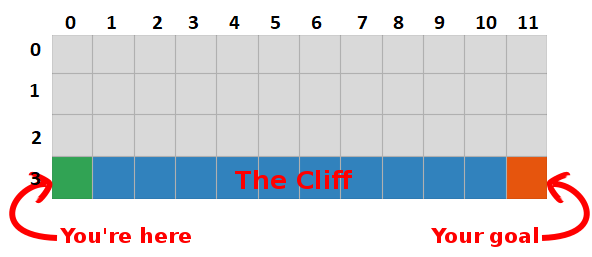

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```

At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

### Helper function to plot values in the environnement

In [9]:
def plot_values(V, title):
  '''
  Plot the values V (may be the value function, actions, or any other values with the right shape) for all states of the environment on the representation of the environment

  Parameters
  ----------
        V: list
            List of the values to plot. Has to be of the right shape (A list of 48 elements).
        title: str
            The title of the plot
  '''

  V = np.reshape(V, (4,12))

  # plot the state-value function
  fig = plt.figure(figsize=(15,5))
  ax = fig.add_subplot(111)
  im = ax.imshow(V, cmap='cool')
  for (j,i),label in np.ndenumerate(V):
      ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
  plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
  plt.title(title)
  plt.show()

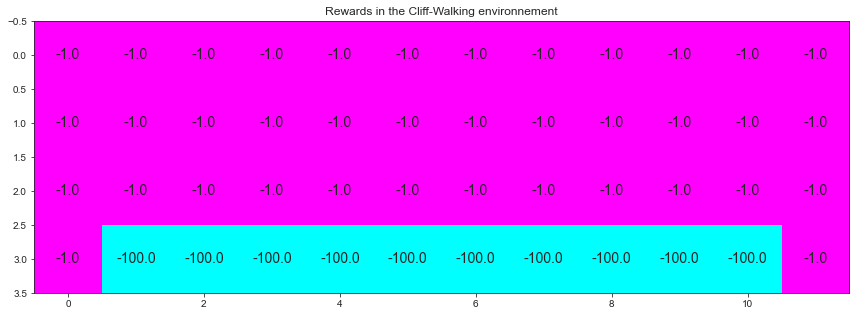

In [10]:
rewards = np.hstack([-1*np.ones(12),-1*np.ones(12),-1*np.ones(12), -1,-100*np.ones(10), -1])
plot_values(rewards, 'Rewards in the Cliff-Walking environnement')


## Value functions

Now that we know what the environment looks like and how it works, we will start evaluating policies. The goal of value functions is to represent the quality of states and actions under a specific policies. We thus need to start by defining a policy.

### Evaluate a path

**Q2 - Deterministic policy :** Define one action for each state of this environment. Make sure the Agent ends up in a Terminal state.  

Indication : Return an array with the same lenght as the number of states (Start state is in position 36).

Reminder : The agent has 4 potential actions:
* UP = 0
* RIGHT = 1
* DOWN = 2
* LEFT = 3

In [11]:
# Define policy
# e.g a policy where the agent always goes right
path = [[np.ones(12)] for i in range(4)]

\Actions (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1): 



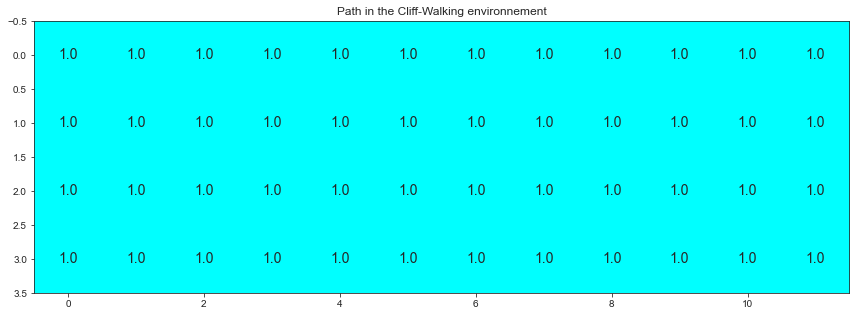

In [12]:
# Print the policy
print("\Actions (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1): \n")
plot_values(path, 'Path in the Cliff-Walking environnement')

In [13]:
# np.hstack function can help you quickly set actions for a row

np.hstack([np.ones(11)*5,2])

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2.])

In [16]:
#build your own
path = [np.hstack([0,1,2,3,4,5,6,7,8,9,10,11]), #12 actions for state 0 to 11
        np.hstack([12,13,14,15,16,17,18,19,20,21,22,23]), #12 actions for state 12 to 23
        np.hstack([24,25,26,27,28,29,30,31,32,33,34,35]), #12 actions for state 24 to 35
        np.hstack([36,37,38,39,40,41,42,43,44,45,46,47])] #12 actions for state 36 to 47

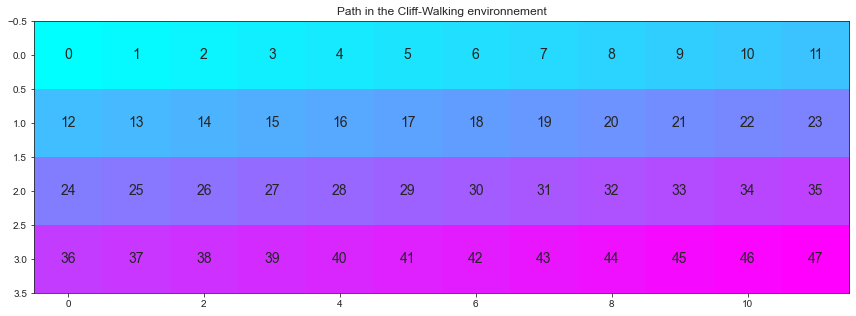

In [17]:
# Print the policy
plot_values(path, 'Path in the Cliff-Walking environnement')

In [18]:
# Convert path into policy
policy = np.zeros((env.nS,env.nA))
for state, action in enumerate(np.hstack(path)):
  # transform action for each state into a probability of taking that action in that state
  policy[state][action.astype(int)] = 1

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
# Observe the behaviour of your agent and compute the policy matrix

# Reset the environment and observe the initial state
state = env.reset()

done = False
timestep_limit = 100
timestep = 0
while not done:
    timestep += 1
    print("Agent in State : "+ str(state))
    action = np.argmax(policy[state])
    new_state, reward, done, prob = env.step(action)
    print(f"Action played {action} and environment updated: new state : {new_state}, reward: {reward}, terminal state : {done}, probability of ending up in new state given state and action : {prob}")
    state = new_state
    if timestep > timestep_limit:
      break

Now that we have a policy, let's evaluate it !

**Q3 - Value functions:** Complete the functions below to compute the state-action-value function $q$ and state-value function $v$.

In [ ]:
def state_action_value_function(env, gamma, policy, state, action, q_values_initials):
    '''
    Return the q table (table of all state action values) for every state and action pairs given a policy.
    '''

    ## Initialize a q-value matrix
    q_values = q_values_initials

    ## TODO

    return q_values

In [ ]:
def state_value_function(policy, q_value, state):
    '''
    Return the v table (table of all state action values) for every state and action pairs given a policy.
    '''
    ## TODO - Use the link between value functions to easely compute the state-values
    return v_values

In [ ]:
gamma = 0.99

# init q-values
q_values = np.zeros((env.nS,env.nA))

# init state-values
v_values = np.zeros(env.nS)


Let's update the values over one episode

In [ ]:


state = env.reset()
done = False

while not done:
    # pick the action according to the policy
    action = np.argmax(policy[state])

    # Update the q-values for the current state and action
    q_values = state_action_value_function(env, gamma, policy, state, action, q_values)


    # Update the state vlue for the current state
    v_values[state] = state_value_function(policy, q_values, state)

    new_state, reward, done, prob = env.step(action)
    print(f"Action played {action} in state {state} and got reward: {reward}")
    print(f"Q value of Action {action} in state {state} is {q_values[state][action]}")

    state = new_state

In [ ]:
plot_values(v_values, 'State Values in the Cliff-Walking environnement episode 1')

Let's do it again on a new episode

In [ ]:
state = env.reset()
done = False

while not done:
    # pick the action according to the policy
    action = np.argmax(policy[state])

    # Update the q-values for the current state and action
    q_values = state_action_value_function(env, gamma, policy, state, action, q_values)


    # Update the state vlue for the current state
    v_values[state] = state_value_function(policy, q_values, state)

    new_state, reward, done, prob = env.step(action)
    print(f"Action played {action} in state {state} and got reward: {reward}")
    print(f"Q value of Action {action} in state {state} is {q_values[state][action]}")

    state = new_state

In [ ]:
plot_values(v_values, 'State Values in the Cliff-Walking environnement episode 2')

In [ ]:
n_episodes = 20

gamma = 0.99
q_values = np.zeros((env.nS,env.nA))
v_values = np.zeros(env.nS)


In [ ]:


for i in range(n_episodes):
    state = env.reset()
    done = False
    clear_output(wait=True)
    plot_values(v_values, 'State Values in the Cliff-Walking environnement episode ' +str(i))
    time.sleep(0.25)
    while not done :
        action = np.argmax(policy[state])
        q_values = state_action_value_function(env, gamma, policy, state, action, q_values)
        v_values[state] = state_value_function(policy, q_values, state)
        new_state, reward, done, prob = env.step(action)
        state = new_state


## Stochasticity

In this part, we will consider a uniform random policy to follow, ie the agent has the same probability to take each action in each state.

Let's observe what happens when select the action at each time step based on exploration or a mix of exploration/exploitation stategy.

### Exploration - Evaluate a random behavior

**Q4 - Exploration :** Observe the computation of the state values with randomly selected actions

In [ ]:
n_episodes = 50

gamma = 0.9
q_values = np.zeros((env.nS,env.nA))
v_values = np.zeros(env.nS)

random_policy = 0.25*np.ones((env.nS,env.nA)) # Equal probability for all cations

In [ ]:
for i in range(n_episodes):
    state = env.reset()
    done = False
    clear_output(wait=True)
    plot_values(v_values, 'State Values in the Cliff-Warlking environnement episode ' +str(i))
    time.sleep(0.01)
    while not done :
        action = # TO DO
        q_values = state_action_value_function(env, gamma, random_policy, state, action, q_values)
        v_values[state] = state_value_function(random_policy, q_values, state)
        new_state, reward, done, prob = env.step(action)
        state = new_state


### Evaluate a stochastic policy

**Q5 - Stochastic policy :** Transform your deterministic policy into a stochastic one : It takes the action you've defined in 1-epsilon% of cases and a random action in epsilon% of cases

In [ ]:
def stochastize_policy(policy, epsilon):
  """
  update a deterministic policy to create a stochastic policy where you choose
  the best action of the initial with probability 1-epsilon and one of the three
  other action with probability epsilon
  Parameters
  ----------
    policy : a policy determined by your path
    epsilon : float between 0 and 1
  """
  # TODO
  return stochastic_policy

In [ ]:
n_episodes = 100

gamma = 0.9
epsilon = 0.3
q_values = np.zeros((env.nS,env.nA))
v_values = np.zeros(env.nS)

#build your own
path = [np.hstack([...]), #12 actions for state 0 to 11
        np.hstack([...]), #12 actions for state 12 to 23
        np.hstack([...]), #12 actions for state 24 to 35
        np.hstack([...])] #12 actions for state 36 to 47

# Convert path into policy
policy = np.zeros((env.nS,env.nA))
for state, action in enumerate(np.hstack(path)):
  # transform action for each state into a probability of taking that action in that state
  policy[state][action.astype(int)] = 1

stochastic_policy = stochastize_policy(policy, epsilon)

In [ ]:
for i in range(n_episodes):
    state = env.reset()
    done = False
    clear_output(wait=True)
    plot_values(v_values, 'State Values in the Cliff-Walking environnement episode ' +str(i))
    time.sleep(0.01)
    while not done :
        action = np.random.choice(list(range(len(stochastic_policy[state]))),p=stochastic_policy[state])
        q_values = state_action_value_function(env, gamma, stochastic_policy, state, action, q_values)
        v_values[state] = state_value_function(stochastic_policy, q_values, state)
        new_state, reward, done, prob = env.step(action)
        state = new_state
